## feature 1 : face mesh - swap

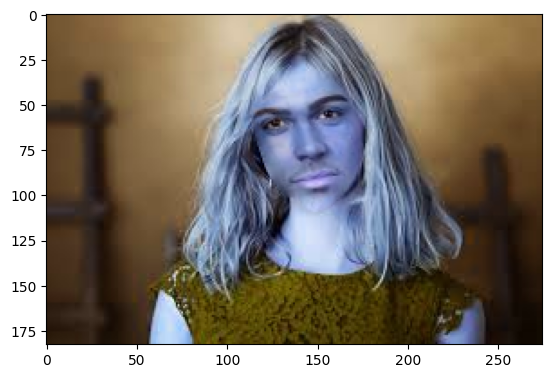

In [2]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import math


# Load face mesh model
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)

# mpDraw.draw_landmarks() 함수 일부 문장 복사
def normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) :
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

# face landmarks detection and get points
def getPoints(img,cvt_color=None,return_cvt_img=True):
    img_rows,img_cols = img.shape[:2]
    if cvt_color:
        img = cv2.cvtColor(img,cvt_color)
    
    result = faceMesh.process(img) # one landmarks of faces 
    
    # landmarks x,y pair
    points = []
    for landmark in result.multi_face_landmarks[0].landmark: # normalized x,y,z points
        points.append(normalized_to_pixel_coordinates(landmark.x,landmark.y,img_cols,img_rows))
        # print(landmark.x,landmark.y)

    if return_cvt_img:
        return points, img
    else:
        return points

# Delaunay triangulation
def getTriangles(img,points):
    h,w = img.shape[:2]
    subdiv = cv2.Subdiv2D((0,0,w,h));
    subdiv.insert(points)
    triangleList = subdiv.getTriangleList()
    triangles = []
    for t in triangleList:
        pt = t.reshape(-1,2)
        if not (pt < 0).sum() and not (pt[:,0] > h).sum() \
                              and not (pt[:,1] > w).sum():
            indice = []
            for i in range(0,3):
                for j in range(0,len(points)):
                    if abs(pt[i][0]-points[j][0]) < 1.0 \
                        and abs(pt[i][1]-points[j][1]) < 1.0:
                        indice.append(j)
            if len(indice) == 3:
                triangles.append(indice)
    
    return triangles

# affine
def warpTriangle(img1,frame,pts1,pts2):
    x1,y1,w1,h1 = cv2.boundingRect(np.float32([pts1])) # x,y : left-top points / w,h : length
    x2,y2,w2,h2 = cv2.boundingRect(np.float32([pts2]))

    roi1 = img1[y1:y1+h1, x1:x1+w1]
    roi2 = frame[y2:y2+h2, x2:x2+w2]
    
    offset1 = np.zeros((3,2),dtype=np.float32)
    offset2 = np.zeros((3,2),dtype=np.float32)
    for i in range(3):
        offset1[i][0], offset1[i][1] = pts1[i][0]-x1,pts1[i][1]-y1
        offset2[i][0], offset2[i][1] = pts2[i][0]-x2,pts2[i][1]-y2

    mtrx = cv2.getAffineTransform(offset1,offset2)
    
    warped = cv2.warpAffine(roi1,mtrx,(w2,h2),None,cv2.INTER_LINEAR,cv2.BORDER_REFLECT101)
    mask = np.zeros((h2,w2),dtype=np.uint8)
    cv2.fillConvexPoly(mask,np.int32(offset2),(255))
    
    warped_masked = cv2.bitwise_and(warped,warped,mask=mask)
    roi2_masked = cv2.bitwise_and(roi2,roi2,mask=cv2.bitwise_not(mask))
    roi2_masked = roi2_masked + warped_masked
    
    frame[y2:y2+h2, x2:x2+w2] = roi2_masked

# main 
# 1. 이미지 로드
frame = cv2.imread("images.jpg")
img1 = cv2.imread("images2.jfif")

# 2. landmarks detection
points1, img1 = getPoints(img1)
points2, frame = getPoints(frame)

img_draw = frame.copy()

# 3. 볼록 선체(convex hull) 구하기 
hullInedx = cv2.convexHull(np.array(points2),returnPoints=False)
hull1 = [points1[int(idx)] for idx in hullInedx]
hull2 = [points2[int(idx)] for idx in hullInedx]

# 4. 볼록 선체 안 들로네 삼각형 좌표 구하기
triangles = getTriangles(frame,hull2)

# 5. 각 삼각형 좌표로 어핀 변환
for i in range(0,len(triangles)):
    t1 = [hull1[triangles[i][j]] for j in range(3)]
    t2 = [hull2[triangles[i][j]] for j in range(3)]
    warpTriangle(img1,img_draw,t1,t2)
    
# 6. 볼록 선체를 마스크로 써서 얼굴 합성
mask = np.zeros(frame.shape[:2],dtype=frame.dtype)
cv2.fillConvexPoly(mask,np.int32(hull2),(255,255,255))
r = cv2.boundingRect(np.float32(hull2))
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
output = cv2.seamlessClone(np.uint8(img_draw),frame,mask,center,cv2.NORMAL_CLONE)

plt.imshow(output)
plt.show()

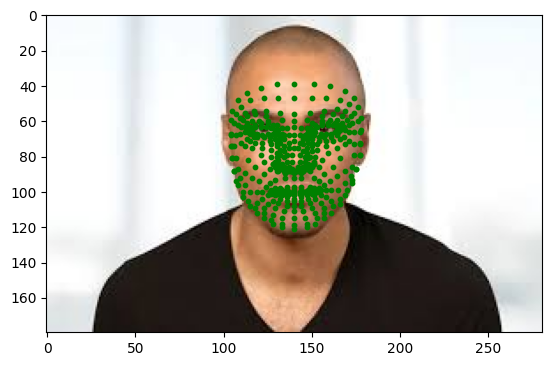

In [18]:
a,img1 = getPoints(img1.copy())
a = np.array(a)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

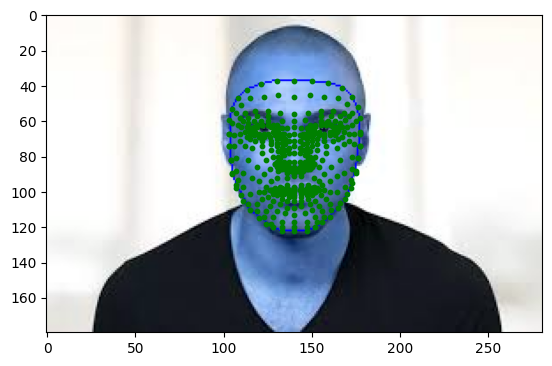

In [19]:
# landmarks
a,img1 = getPoints(img1.copy())
# convex hull
a = np.array(a)
hull1 = np.array(hull1)
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

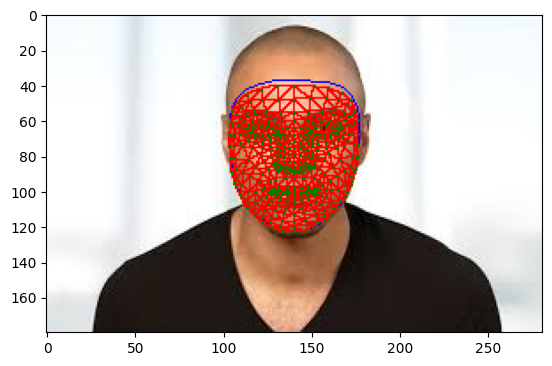

In [20]:
# landmarks
a,img1 = getPoints(img1.copy())
# convex hull
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
# delaunay triangulation
h,w = img1.shape[:2]
subdiv = cv2.Subdiv2D((0,0,w,h))
subdiv.insert(a)
triangleList = subdiv.getTriangleList()

for t in triangleList:
    pts = t.reshape(-1,2).astype(np.int32)
    if (pts < 0).sum() or (pts[:,0]>w).sum() or (pts[:,1] > h).sum():
        continue
    cv2.polylines(img1,[pts],True,(0,0,255),1,cv2.LINE_4)


a = np.array(a)
hull1 = np.array(hull1)
plt.scatter(a[:,0],a[:,1],s=1,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()



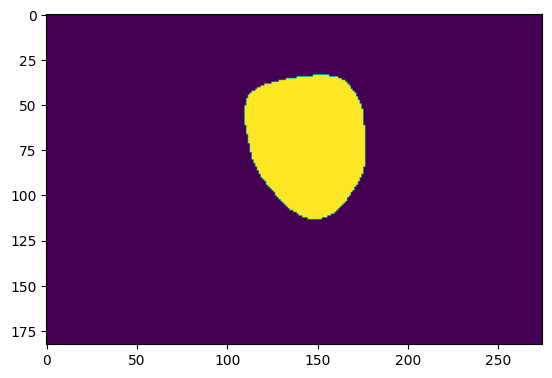

In [23]:
plt.imshow(mask)
plt.show()


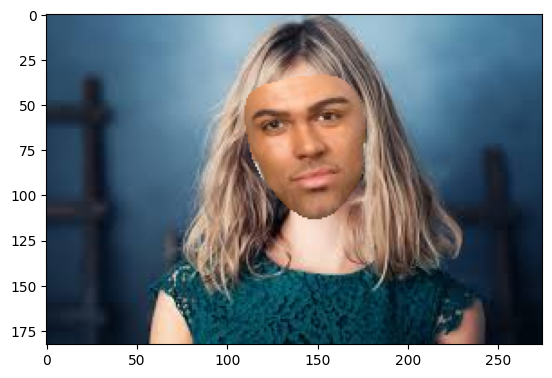

In [30]:
plt.imshow(np.uint8(img_draw))
plt.show()

In [2]:
from moviepy.editor import VideoFileClip

VideoFileClip('./face_swap.mp4').speedx(6).write_gif('swapFace.gif')

MoviePy - Building file swapFace.gif with imageio.


In [37]:
import cv2
import mediapipe as mp
import numpy as np

# 선글라스 이미지 읽어오기
sunglass = cv2.imread('sunglasses.jpg', cv2.IMREAD_UNCHANGED)

# Mediapipe를 이용한 Face landmark detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# Dlib를 이용한 3D 모델링
model_points = np.array([
                         (0.0, 0.0, 0.0),             # Nose tip
                         (0.0, -330.0, -65.0),        # Chin
                         (-225.0, 170.0, -135.0),     # Left eye left corner
                         (225.0, 170.0, -135.0),      # Right eye right corner
                         (-150.0, -150.0, -125.0),    # Left Mouth corner
                         (150.0, -150.0, -125.0)      # Right mouth corner
                         ])

def put_sunglass(img, landmarks):
    # 랜드마크 좌표 추출
    nose_tip = landmarks[4][1], landmarks[4][0]
    chin = landmarks[10][1], landmarks[10][0]
    left_eye = landmarks[159]
    right_eye = landmarks[386]
    left_mouth = landmarks[5][1], landmarks[5][0]
    right_mouth = landmarks[6][1], landmarks[6][0]

    # 랜드마크를 이용한 얼굴의 각도 계산
    image_points = np.array([
                             nose_tip,     # Nose tip
                             chin,         # Chin
                             left_eye,     # Left eye left corner
                             right_eye,    # Right eye right corner
                             left_mouth,   # Left Mouth corner
                             right_mouth   # Right mouth corner
                             ], dtype="double")
    size = img.shape
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double")
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
    # 선글라스 이미지 크기 조정
    h, w = sunglass.shape[:2]
    sunglasses_width = int(abs(left_eye[0] - right_eye[0]) * 1.2)
    sunglasses_height = int(sunglasses_width * h / w)

    # 선글라스 회전 및 이동
    rotation_mat = cv2.Rodrigues(rotation_vector)[0]
    project_matrix = np.hstack((rotation_mat, translation_vector))
    camera_position = np.dot(-rotation_mat.T, translation_vector)
    yaw, pitch, roll = [np.radians(_) for _ in camera_position]

    # 선글라스 회전 변환
    rotation_matrix = np.zeros(shape=(3, 3))
    cosYaw = np.cos(yaw)
    sinYaw = np.sin(yaw)
    rotation_matrix[0, 0] = cosYaw
    rotation_matrix[0, 2] = sinYaw
    rotation_matrix[2, 0] = -sinYaw
    rotation_matrix[2, 2] = cosYaw

    cosPitch = np.cos(pitch)
    sinPitch = np.sin(pitch)
    rotation_matrix[1, 1] = cosPitch
    rotation_matrix[1, 2] = -sinPitch
    rotation_matrix[2, 1] = sinPitch
    rotation_matrix[2, 2] *= cosPitch

    cosRoll = np.cos(roll)
    sinRoll = np.sin(roll)
    rotation_matrix[0, 0] *= cosRoll
    rotation_matrix[0, 1] = -sinRoll
    rotation_matrix[1, 0] = sinRoll
    rotation_matrix[1, 1] *= cosRoll

    # 선글라스 이동 변환
    scale = sunglasses_width / w
    T = np.array([[1, 0, sunglasses_width/2],
                    [0, 1, sunglasses_height/2],
                    [0, 0, 0],
                    [0, 0, 1]])
                    
    R = np.array([
                [scale, 0, 0],
                [0, scale, 0],
                [0, 0, scale]
                ])
    M = T @ R @ np.hstack((rotation_matrix, translation_vector)).astype(np.float32)
    M = M[:3,:3]
    warped_sunglasses = cv2.warpPerspective(sunglass, M, (img.shape[1], img.shape[0]))
    warped_sunglasses
    # 이미지에 선글라스 합성
    mask = cv2.cvtColor(warped_sunglasses[:, :, :3], cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)[1]
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(img, img, mask=mask_inv)
    sunglasses_fg = cv2.bitwise_and(warped_sunglasses[:, :, :3], warped_sunglasses[:, :, 3:], mask=mask)
    img = cv2.add(img_bg, sunglasses_fg)

    return img






In [38]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=10,min_detection_confidence=0.7)

while True:
    ret, img = cap.read()
    img = cv2.flip(img, 1)

    # Face landmark detection
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = faceMesh.process(img_RGB)
    
    if results is not None:
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                landmarks = np.array(
                    [(lmk.x, lmk.y) for lmk in face_landmarks.landmark],
                    dtype=np.float32
                )
                # Apply sunglasses filter to face landmarks
                landmarks[:, :2] = np.round(landmarks[:, :2] * np.array([img.shape[1], img.shape[0]]))
                img = put_sunglass(img, landmarks)

    cv2.imshow('Sunglasses Filter', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

ValueError: could not broadcast input array from shape (3,6,4) into shape (0,0,3)

In [39]:
cap.release()
cv2.destroyAllWindows()

In [22]:
sunglass = cv2.imread('sunglass.png', cv2.IMREAD_UNCHANGED)
print(sunglass.shape)
plt.imshow(sunglass)

(480, 960, 4)


NameError: name 'plt' is not defined

In [50]:
def rotate_image(image, angle):
    """Rotate an image by a given angle in degrees."""
    # Get image size
    height, width = image.shape[:2]

    # Calculate image center
    center = (width / 2, height / 2)

    # Define rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate image
    rotated_image = cv2.warpAffine(image, M, (width, height))

    return rotated_image

def extract_landmarks(image):
    with mp.solutions.face_mesh.FaceMesh() as face_mesh:
        results = face_mesh.process(image)
        if results.multi_face_landmarks:
            return results.multi_face_landmarks[0]
        else:
            return None
        
def put_sunglass(image, face_landmarks):
    sunglasses = cv2.imread("sunglasses.png", cv2.IMREAD_UNCHANGED)
    
    # Get the position and size of the sunglasses from the landmarks
    left_eye = face_landmarks.landmark[mp.solutions.face_mesh.FaceMesh.FaceMeshLandmark.LEFT_EYE]
    right_eye = face_landmarks.landmark[mp.solutions.face_mesh.FaceMesh.FaceMeshLandmark.RIGHT_EYE]
    nose_tip = face_landmarks.landmark[mp.solutions.face_mesh.FaceMesh.FaceMeshLandmark.NOSE_TIP]
    
    sunglasses_width = int(abs(right_eye.x - left_eye.x) * image.shape[1])
    sunglasses_height = int(sunglasses_width * sunglasses.shape[0] / sunglasses.shape[1])
    sunglasses_resized = cv2.resize(sunglasses, (sunglasses_width, sunglasses_height))
    
    # Calculate the rotation and translation for the sunglasses
    dx = right_eye.x - left_eye.x
    dy = right_eye.y - left_eye.y
    angle = -np.arctan2(dy, dx)
    sunglasses_rotated = rotate_image(sunglasses_resized, angle)
    sunglasses_center_x = int(nose_tip.x * image.shape[1])
    sunglasses_center_y = int(nose_tip.y * image.shape[0])
    tx = sunglasses_center_x - int(sunglasses_rotated.shape[1] / 2)
    ty = sunglasses_center_y - int(sunglasses_rotated.shape[0] / 3.5)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    sunglasses_translated = cv2.warpAffine(sunglasses_rotated, M, (image.shape[1], image.shape[0]))
    
    # Blend the sunglasses with the image
    alpha_s = sunglasses_translated[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s
    for c in range(0, 3):
        image[:, :, c] = (alpha_s * sunglasses_translated[:, :, c] + alpha_l * image[:, :, c])
    
    return image


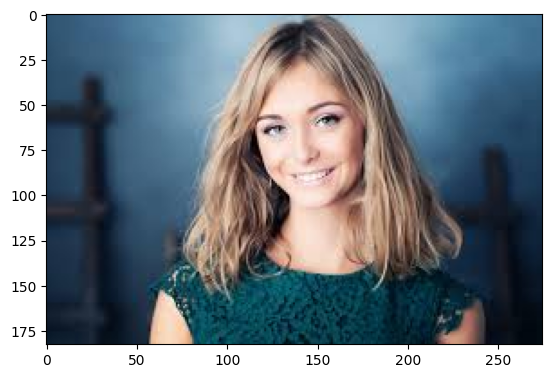

In [25]:

# landmarks = extract_landmarks(img)
# if landmarks is not None:
#     img = put_sunglass(img,landmarks)

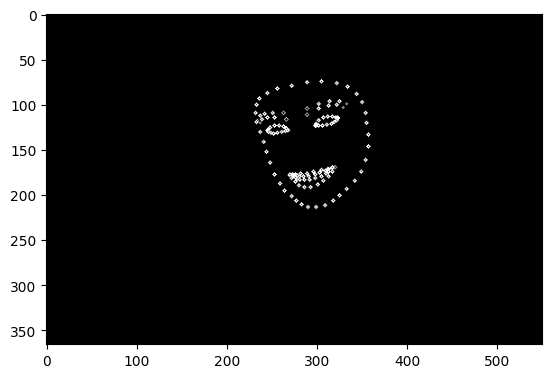

In [96]:
img = cv2.imread('./images.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = img.copy()
image_cols, image_rows = img.shape[1]*2,img.shape[0]*2 
img2 = cv2.resize(img2,(img.shape[1]*2,img.shape[0]*2))
landmark_list = []

with mp.solutions.face_mesh.FaceMesh() as face_mesh:
    results = face_mesh.process(img2)
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmark_list.append(face_landmarks)
    #         landmarks = np.array(
    #             [normalized_to_pixel_coordinates(lmk.x,lmk.y,img2.shape[1],img2.shape[0])\
    #                 for lmk in face_landmarks.landmark],
    #             dtype=np.float32)
            
idx_to_coordinates = {}
for idx,landmark in enumerate(landmark_list[0].landmark):
    landmark_px = normalized_to_pixel_coordinates(landmark.x, landmark.y,
                                                   image_cols, image_rows)
    if landmark_px:
        idx_to_coordinates[idx] = landmark_px

a = np.zeros_like(img2)   
     
for conn in mpFaceMesh.FACEMESH_CONTOURS:
    start_idx = conn[0]
    end_idx = conn[1]
    # cv2.line(a,idx_to_coordinates[start_idx],idx_to_coordinates[end_idx],color=(255,255,255))        
    cv2.circle(a,idx_to_coordinates[start_idx],radius=1, color=(255,255,255))        
    cv2.circle(a,idx_to_coordinates[end_idx],radius=2,color=(255,255,255))        

plt.imshow(a)


[frozenset({(270, 409), (176, 149), (37, 0), (84, 17), (318, 324), (293, 334), (386, 385), (7, 163), (33, 246), (17, 314), (374, 380), (251, 389), (390, 373), (267, 269), (295, 285), (389, 356), (173, 133), (33, 7), (377, 152), (158, 157), (405, 321), (54, 103), (263, 466), (324, 308), (67, 109), (409, 291), (157, 173), (454, 323), (388, 387), (78, 191), (148, 176), (311, 310), (39, 37), (249, 390), (144, 145), (402, 318), (80, 81), (310, 415), (153, 154), (384, 398), (397, 365), (234, 127), (103, 67), (282, 295), (338, 297), (378, 400), (127, 162), (321, 375), (375, 291), (317, 402), (81, 82), (154, 155), (91, 181), (334, 296), (297, 332), (269, 270), (150, 136), (109, 10), (356, 454), (58, 132), (312, 311), (152, 148), (415, 308), (161, 160), (296, 336), (65, 55), (61, 146), (78, 95), (380, 381), (398, 362), (361, 288), (246, 161), (162, 21), (0, 267), (82, 13), (132, 93), (314, 405), (10, 338), (178, 87), (387, 386), (381, 382), (70, 63), (61, 185), (14, 317), (105, 66), (300, 293),

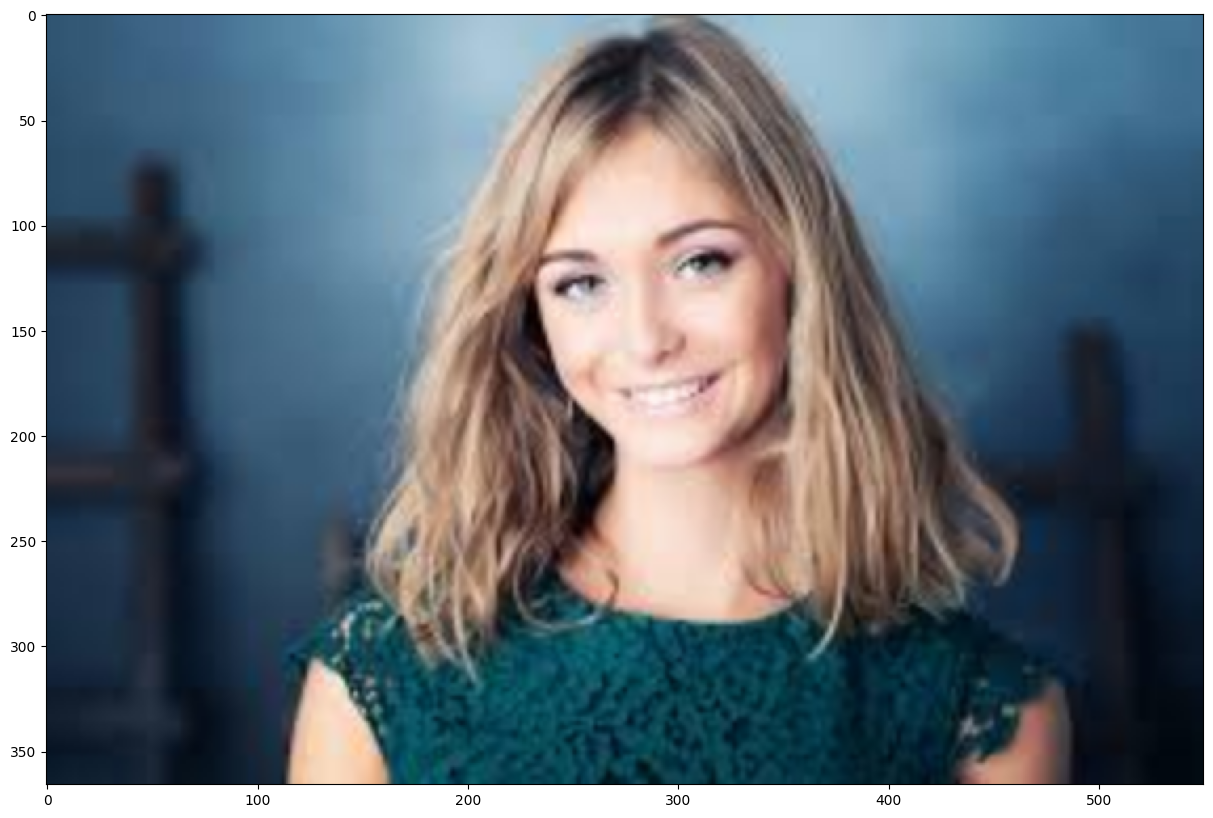

In [98]:
import matplotlib.pyplot as plt
# Location
con_points = np.array([
    mpFaceMesh.FACEMESH_CONTOURS,
    mpFaceMesh.FACEMESH_LEFT_EYE,
    mpFaceMesh.FACEMESH_RIGHT_EYE,
    mpFaceMesh.FACEMESH_IRISES,
    mpFaceMesh.FACEMESH_LIPS
])

#i=386

# for i,l in enumerate(mpFaceMesh.FACEMESH_CONTOURS):
#     cv2.putText(img2,f'{i}',landmarks[l],cv2.FONT_HERSHEY_PLAIN,0.6, (0,255,0),1)

plt.figure(figsize=(20,10))
plt.imshow(img2)
# plt.scatter(landmarks[:,0],landmarks[:,1])
print(con_points)

(270, 409)
(176, 149)
(37, 0)
(84, 17)
(318, 324)
(293, 334)
(386, 385)
(7, 163)
(33, 246)
(17, 314)
(374, 380)
(251, 389)
(390, 373)
(267, 269)
(295, 285)
(389, 356)
(173, 133)
(33, 7)
(377, 152)
(158, 157)
(405, 321)
(54, 103)
(263, 466)
(324, 308)
(67, 109)
(409, 291)
(157, 173)
(454, 323)
(388, 387)
(78, 191)
(148, 176)
(311, 310)
(39, 37)
(249, 390)
(144, 145)
(402, 318)
(80, 81)
(310, 415)
(153, 154)
(384, 398)
(397, 365)
(234, 127)
(103, 67)
(282, 295)
(338, 297)
(378, 400)
(127, 162)
(321, 375)
(375, 291)
(317, 402)
(81, 82)
(154, 155)
(91, 181)
(334, 296)
(297, 332)
(269, 270)
(150, 136)
(109, 10)
(356, 454)
(58, 132)
(312, 311)
(152, 148)
(415, 308)
(161, 160)
(296, 336)
(65, 55)
(61, 146)
(78, 95)
(380, 381)
(398, 362)
(361, 288)
(246, 161)
(162, 21)
(0, 267)
(82, 13)
(132, 93)
(314, 405)
(10, 338)
(178, 87)
(387, 386)
(381, 382)
(70, 63)
(61, 185)
(14, 317)
(105, 66)
(300, 293)
(382, 362)
(88, 178)
(185, 40)
(46, 53)
(284, 251)
(400, 377)
(136, 172)
(323, 361)
(13, 312)
(21